In [1]:
# run this same experiment again but instead of 2,0,0 -> 0,0,2 have 2,0,0 -> 0,1,1 this would be cool 
# declaring all dependancies    
import qutip as qt
import numpy as np
from quantum_logical.pulsesim import QuantumSystem, Pulse
from quantum_logical.pulsesim.mode import QubitMode, SNAILMode, CavityMode
from quantum_logical.pulsesim.build_hamiltonian import Build_hamiltonian
import matplotlib.pyplot as plt
from quantum_logical.channel import AmplitudeDamping, PhaseDamping
from quantum_logical.trotter import TrotterGroup
from quantum_logical.interaction import ConversionGainInteraction
from qutip import Options
from tqdm import tqdm
from progressbar import progressbar
from threading import Thread
from multiprocessing.pool import Pool, ThreadPool
from numpy.linalg import eig
from quantum_logical.creating_operators import Creating_operators
from quantum_logical.operators import selective_destroy

# opts = Options(nsteps=1e6, atol=1e-8, rtol=1e-6)
# p_bar = qt.ui.TextProgressBar()  # None
opts = {"nsteps": 1e6, "atol": 1e-8, "rtol": 1e-6, "progress_bar": "text"}

In [2]:
# adding all of the necessary elements to the full creation of the system 
qubit_dim = 3

# frequencies 
w1_un = 4
w2_un = 6
ws_un = 5.6666666666666666

freqs = [w1_un, w2_un, ws_un]

# coupling strength coefficient 
g1s = 2 * np.pi * 0.05467
g2s = 2 * np.pi * 0.0435

# create array of the coefficients should be useful 
gs = [g1s, g2s]

g_ab = .1

# unknown value as of now 
g3 = .1

a1 = a2 = .01
alpha = [a1, a2]


In [3]:
# creating the qubits and the hilbert space
qubit1 = QubitMode(
    mode_type="Qubit", name="q1", dim=qubit_dim, freq=w1_un, alpha=-0.161, T1=1e2, T2=5e1
)
qubit2 = QubitMode(
    mode_type="Qubit", name="q2", dim=qubit_dim, freq=w2_un, alpha=-0.1275, T1=1e2, T2=5e1
)
qubits = [qubit1, qubit2]
snail = SNAILMode(mode_type="Snail", name="s", freq=ws_un, g3=0.3, dim=10, T1=1e3, T2=5e2)
_couplings = {
    frozenset([qubit1, snail]): 2 * np.pi * 0.05467,
    frozenset([qubit2, snail]): 2 * np.pi * 0.0435
}

qs = QuantumSystem(qubits + [snail], couplings=_couplings)

system = []
system.extend(qubits)
system.extend([snail])

In [4]:
# creating the full dim operators 
qubit1_a = qt.tensor(qubit1.a, qt.qeye(qubit_dim), qt.qeye(snail.dim))
qubit1_a_dag = qubit1_a.dag()
qubit2_a = qt.tensor(qt.qeye(qubit_dim), qubit2.a, qt.qeye(snail.dim))
qubit2_a_dag = qubit2_a.dag()
snail_a = qt.tensor(qt.qeye(qubit_dim), qt.qeye(qubit_dim), snail.a)
snail_a_dag = snail_a.dag()

snail_field = (snail_a_dag + snail_a)
qubit1_field = (qubit1_a_dag + qubit1_a)
qubit2_field = (qubit2_a_dag + qubit2_a)

In [5]:
H = Creating_operators(qubit_count=2, qubit_dim=3)

# creating the operators 
fund_ops_list = []

fund_ops_list.append(H.create_ops_unconventional_annhilation(from_level=0, to_level=1))  # this is not necessary with the new addition for the operator 
fund_ops_list.append(H.create_ops_unconventional_annhilation(from_level=1, to_level=2))

In [9]:
H_qubits = [freqs[i] * (qs.modes_a_dag[qubits[i]] * qs.modes_a[qubits[i]]) for i in range(len(qubits))]
H_qubit_qubit = [g_ab * (qs.modes_field[qubits[0]] * qs.modes_field[qubits[1]])]
H_qubit_snail = [gs[i] * (qs.modes_field[snail] * qs.modes_field[qubits[i]]) for i in range(len(qubits))]
H_snail_non_lin = [g3 * ((qs.modes_field[snail]) ** 3)]
H_qubit_non_lin = [alpha[i] * ((qs.modes_field[qubits[i]]) ** 4) for i in range(len(qubits))]

H_total_no_time1 = []
H_total_no_time1.extend(H_qubits)
H_total_no_time1.extend(H_qubit_qubit)
H_total_no_time1.extend(H_qubit_snail)
H_total_no_time1.extend(H_snail_non_lin)
H_total_no_time1.extend(H_qubit_non_lin)
H_total_no_time = sum(H_total_no_time1)

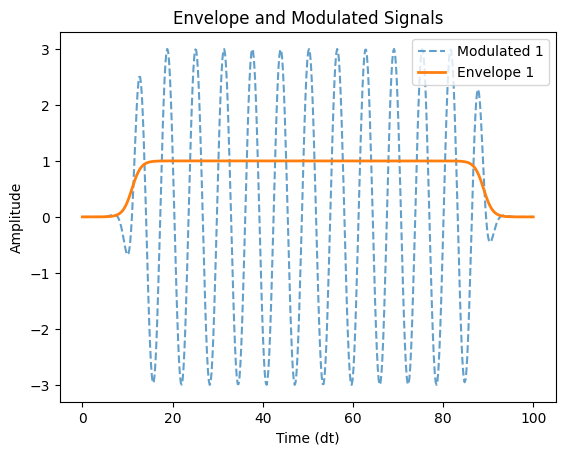

In [15]:
H_pump = (snail_field)
args = {"shape": Pulse.smoothbox, "shape_params": {"t0": .05 * 100, "width": .9 * 100}}
pulse = Pulse(omega=1, amp=3)
Pulse.plot_pulse([(pulse, args)], np.linspace(0,100,500))

In [18]:
# initial state of the system
psi0 = qt.tensor(qt.basis(qubit_dim, 2), qt.basis(qubit_dim, 0), qt.basis(snail.dim))

In [ ]:
# work on getting the x-gate at the time that is required 
time_x_gate = 50 
time_x = np.linspace(0, time_x_gate, 100)

T1 = 1
T2 = 1
amp_damp_channel = AmplitudeDamping(T1, num_qubits=2, hilbert_space_dim=qubit_dim)
phase_damp_channel = PhaseDamping(T1, T2, num_qubits=2, hilbert_space_dim=qubit_dim)
collapse = [amp_damp_channel, phase_damp_channel]


freqs = np.linspace(0, 4, 10)
amps = np.linspace(0, 4, 10)
amp_freq = [(i, j) for i in freqs for j in amps]

psi_expected_x_gate = qt.tensor(qt.basis(qubit_dim, 1), qt.basis(qubit_dim, 0), qt.basis(snail.dim))

def x_gate_task(amp_freq):
    freq, amp = amp_freq
    
    args = {"shape": Pulse.smoothbox, "shape_params": {"t0": .05 * time_x_gate, "width": .9 * time_x_gate}}
    pulse = Pulse(omega=freq, amp=amp)

    H = [[H_pump, pulse.drive], H_total_no_time]

    results = qt.mesolve(H=H, rho0=psi0, tlist=time_x, options=opts, args=args, c_ops=collapse)

    fid = qt.fidelity(psi_expected_x_gate, results.states[-1])

    return fid, amp, freq

res = qt.parallel.parallel_map(x_gate_task, amp_freq, progress_bar=True)

# this will only give the operator that takes you from one state to the other this will not be the overall x operator 
